In [376]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
from collections import Counter
from TrackReconstruction_functions import *

pd.options.mode.chained_assignment = None  # Disable the warning

pressure=1
# diffusion="5.0percent"
diffusion="0.1percent"
# file_id = "1"
file_id = "2954"
# file_id = "2638"


# hits_true = pd.read_hdf(f"../data/ATPC_0nubb/ATPC_0nubb_{pressure}bar_smear_{file_id}.h5", "MC/hits")
# hits      = pd.read_hdf(f"../data/ATPC_0nubb/ATPC_0nubb_{pressure}bar_{diffusion}_smear_{file_id}.h5", "MC/hits")

hits_true = pd.read_hdf(f"../data/ATPC_Tl/ATPC_Tl_{pressure}bar_smear_{file_id}.h5", "MC/hits")
hits      = pd.read_hdf(f"../data/ATPC_Tl/ATPC_Tl_{pressure}bar_{diffusion}_smear_{file_id}.h5", "MC/hits")

# hits = pd.read_hdf(f"../data/Trackreco/ATPC_Tl_{pressure}bar_{diffusion}_filtered.h5", "MC/hits")
# hits_true = pd.read_hdf(f"../data/Trackreco/ATPC_Tl_{pressure}bar_nexus_filtered.h5", "MC/hits")
# hits_true["z"]= hits_true["z"]+3000

display(hits)

event_list = hits.event_id.unique()

print(hits.event_id.unique())

,event_id,x,y,z,energy
0,103725000,2596.427734,-1502.275635,864.970032,0.000099
1,103725000,2586.135254,-1537.228882,865.001404,0.000099
2,103725000,2618.277100,-1579.841675,865.311890,0.000074
3,103725000,2582.771484,-1501.382202,865.585388,0.000273
4,103725000,2602.209473,-1537.203003,866.297729,0.000645
...,...,...,...,...,...
225265,103725059,-2562.337158,-1100.591797,1135.122803,0.000496
225266,103725059,-2574.917236,-1085.169922,1135.458374,0.000074
225267,103725059,-2425.732422,-1273.979126,1135.968872,0.000050
225268,103725059,-2459.903076,-1264.908325,1137.431396,0.000025


[103725000 103725001 103725002 103725003 103725004 103725005 103725006
 103725007 103725008 103725009 103725010 103725011 103725012 103725013
 103725014 103725015 103725016 103725017 103725018 103725019 103725020
 103725021 103725022 103725023 103725024 103725025 103725026 103725027
 103725028 103725029 103725030 103725031 103725032 103725033 103725034
 103725035 103725036 103725037 103725038 103725039 103725040 103725041
 103725042 103725043 103725044 103725045 103725046 103725047 103725048
 103725049 103725050 103725051 103725052 103725053 103725054 103725055
 103725056 103725057 103725058 103725059]


In [377]:
eid=320000
eid=event_list[12]

data = hits[hits.event_id ==eid]
data_true = hits_true[hits_true.event_id ==eid]
display(data_true)

,event_id,x,y,z,energy
12779,103725012,109.633827,751.442200,3283.329834,0.038490
12780,103725012,108.871841,752.739441,3283.890869,0.003224
12781,103725012,166.579025,1121.861328,3306.322754,0.033207
12782,103725012,-28.038910,-921.737183,4151.002441,0.030033
12783,103725012,-54.179226,-471.371948,4163.796387,0.008358
...,...,...,...,...,...
13768,103725012,42.579624,-507.641327,5937.412598,0.000347
13769,103725012,37.474842,-472.227234,5937.481445,0.000174
13770,103725012,37.396572,-472.371429,5937.570801,0.000670
13771,103725012,43.810677,-506.653595,5937.574707,0.001761


In [378]:

Diff_smear, energy_threshold, diff_scale_factor, radius_sf, voxel_sf = InitializeParams(pressure, diffusion)
# voxel_sf=1.1
# energy_threshold=0
print("Diffussion smear is: ",        Diff_smear,            "mm/sqrt(cm)")
print("Energy threshold is: ",        1000*energy_threshold, "keV")
print("diffision scale factor is: ",  diff_scale_factor)
print("Radius scale factor is: ",     radius_sf)
print("Voxel scale factor is: ",      voxel_sf)

mean_sigma = round(diff_scale_factor*Diff_smear*np.sqrt(0.1*data.z.mean()))


# Calculate the detector half-length
det_size = int(np.cbrt(6000**3/pressure)/2.0) 

# Create the bins ---- 
xbw  = mean_sigma
xmin = -det_size - mean_sigma/2 
xmax = det_size  + mean_sigma/2

ybw  = mean_sigma
ymin = -det_size - mean_sigma/2 
ymax = det_size  + mean_sigma/2

# This shifts the z pos of the events so 0 is at anode
# can set this to zero
z_shift = det_size
# z_shift = 0

zbw=mean_sigma
zmin=-det_size + z_shift - mean_sigma/2 
zmax=det_size + z_shift + mean_sigma/2

# bins for x, y, z
xbins = np.arange(xmin, xmax+xbw, xbw)
ybins = np.arange(ymin, ymax+ybw, ybw)
zbins = np.arange(zmin, zmax+zbw, zbw)

# center bins for x, y, z
xbin_c = xbins[:-1] + xbw / 2
ybin_c = ybins[:-1] + ybw / 2
zbin_c = zbins[:-1] + zbw / 2

Diffussion smear is:  0.95 mm/sqrt(cm)
Energy threshold is:  0.4 keV
diffision scale factor is:  4
Radius scale factor is:  2
Voxel scale factor is:  2.1


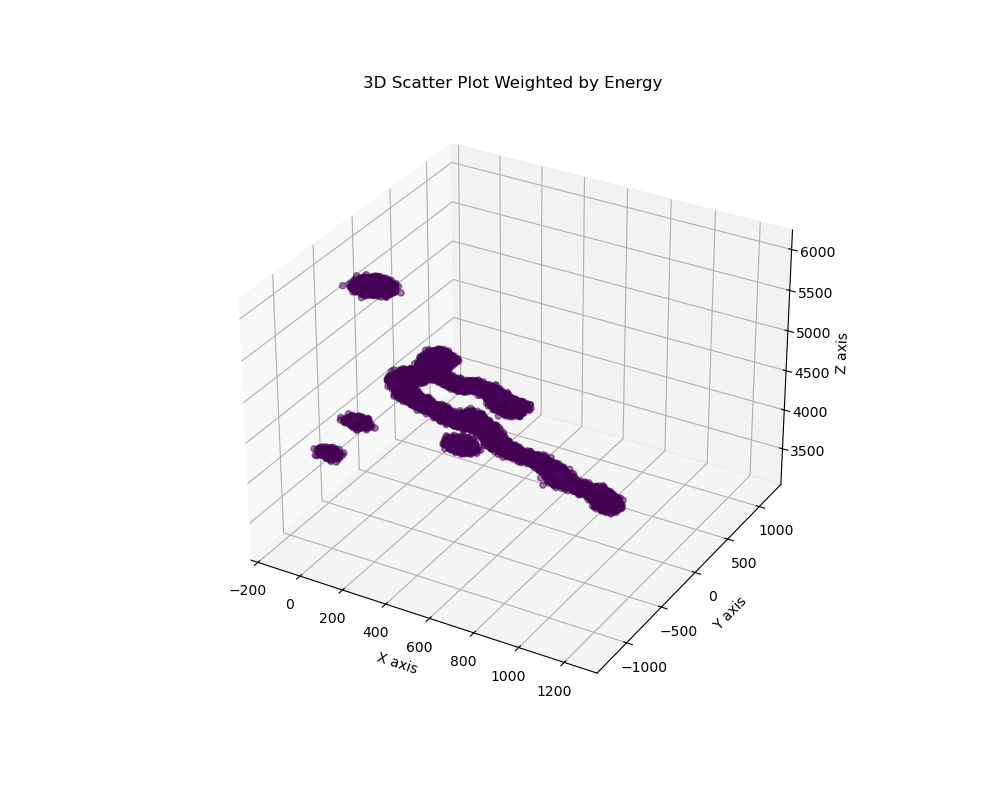

In [379]:
%matplotlib widget 

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Normalize the energy values for the colors
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(data.energy.min(), data.energy.max())
colors = cmap(norm(data.energy))


# Plot the scatter plot
scatter = ax.scatter(data.x, data.y, data.z, c=colors, marker='o', alpha=0.5)
ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o', c="DarkOrange")

# ax.scatter(data_true['x'], data_true['y'], data_true['z']+3000, marker='o', c="DarkRed")

# Add color bar to indicate energy values
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array(data.energy)
# cbar = plt.colorbar(mappable)
# cbar.set_label('Energy')

# Set labels and title
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('3D Scatter Plot Weighted by Energy')

plt.show()

In [380]:
# There seems to be a duplicate row sometimes
data = data.drop_duplicates()

# display(data)
data = data[['event_id','x', 'y', 'z',"energy"]]

# then sort it based on the x,y,z
data = data.sort_values(by=['x', "y", "z"]).reset_index(drop=True)


display(data)

,event_id,x,y,z,energy
0,103725012,-133.002228,-488.119995,4175.024414,0.000025
1,103725012,-123.154015,-519.655701,4174.597168,0.000025
2,103725012,-118.231834,-485.044189,4164.073242,0.000050
3,103725012,-114.809692,-495.231323,4142.643555,0.000050
4,103725012,-114.483177,-469.147064,4149.804199,0.000025
...,...,...,...,...,...
6043,103725012,1234.337036,-741.490784,4415.062012,0.000025
6044,103725012,1234.786621,-799.549133,4403.152344,0.000149
6045,103725012,1235.240479,-800.082703,4438.018066,0.000050
6046,103725012,1237.153564,-764.224426,4389.728516,0.000025


,event_id,x,y,z,energy
0,103725012,-133.002228,-488.119995,4175.024414,0.000025
1,103725012,-123.154015,-519.655701,4174.597168,0.000025
2,103725012,-118.231834,-485.044189,4164.073242,0.000050
3,103725012,-114.809692,-495.231323,4142.643555,0.000050
4,103725012,-114.483177,-469.147064,4149.804199,0.000025
...,...,...,...,...,...
6043,103725012,1234.337036,-741.490784,4415.062012,0.000025
6044,103725012,1234.786621,-799.549133,4403.152344,0.000149
6045,103725012,1235.240479,-800.082703,4438.018066,0.000050
6046,103725012,1237.153564,-764.224426,4389.728516,0.000025


Mean z: 4512.8193  diffusion =  81
Mean Sigma:  81
Total groups created: 7


,x,y,z,energy,group_id
0,-59.269302,-479.458923,4162.250977,0.064937,0
1,-21.287706,-920.494263,4149.472656,0.020737,1
2,22.200111,-499.403381,5919.726074,0.112690,2
3,41.537476,-460.899200,5956.475586,0.089227,2
4,78.755119,-461.130188,5919.776367,0.046712,2
5,117.588669,759.218689,3280.800049,0.040218,3
6,161.189270,1120.343262,3300.750977,0.029130,4
7,660.539246,-1159.699707,5000.530273,0.131130,5
8,680.958435,-1059.474609,5260.024414,0.020461,5
9,697.889160,-1142.704102,4981.268555,0.008638,5


51 2.5684119194047526


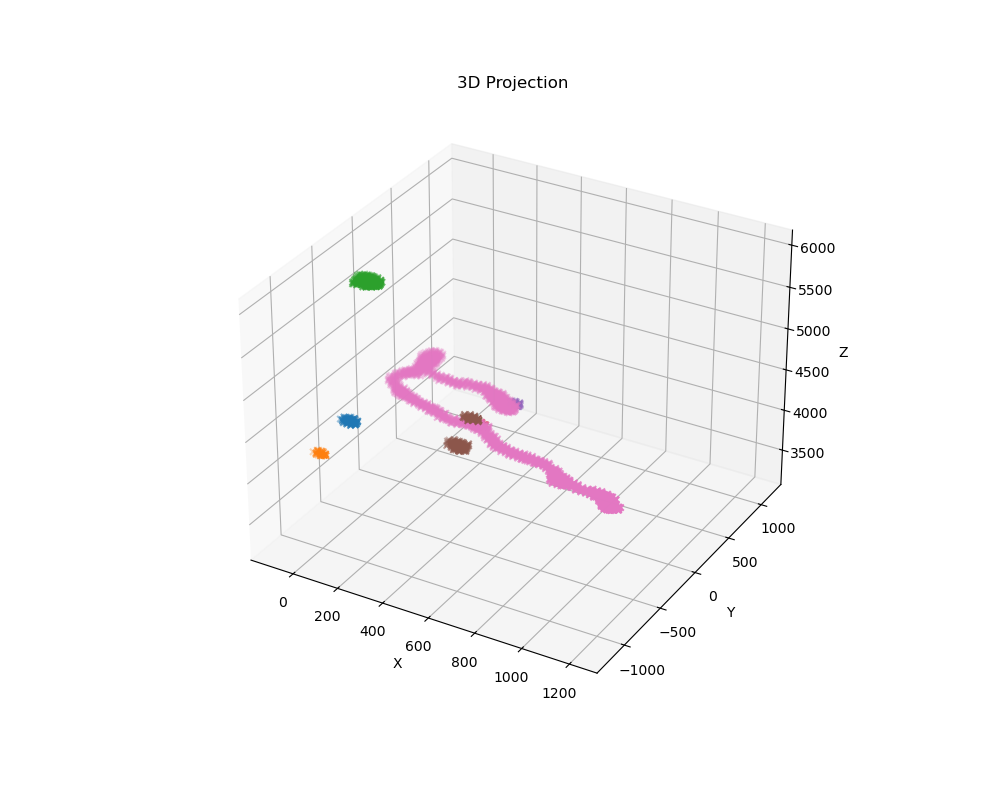

In [388]:

display(data)

print("Mean z:", data.z.mean(), " diffusion = ", mean_sigma)
print("Mean Sigma: ", mean_sigma)


# Apply grouping
# voxel size and parameters
voxel_size = mean_sigma  # mm
threshold = voxel_size*voxel_sf

data_copy = data.copy()
df_merged = GroupHits(data_copy, xmin, ymin, zmin, voxel_size, threshold)

# If we have too many groups then bump up the voxel size since the track was broken too much
if (len(df_merged.group_id.unique()) > 10):
    print("Running grouping again")
    df_merged = GroupHits(data_copy, xmin, ymin, zmin, voxel_size, voxel_size*(voxel_sf+1))

df_merged = CutandRedistibuteEnergy(df_merged, energy_threshold)


# Apply clustering
node_centers_df = []

for gid in sorted(df_merged.group_id.unique()):
    temp_df = df_merged[df_merged.group_id == gid]
    temp_df.reset_index(drop=True, inplace=True)
    node_centers_df.append(Cluster(temp_df, mean_sigma))

node_centers_df = pd.concat(node_centers_df, ignore_index=True)

display(node_centers_df)
print(len(node_centers_df), node_centers_df.energy.sum())

# -------

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for gid in sorted(df_merged.group_id.unique()):
    # ax.scatter(data['x'], data['y'], data['z'], marker='o',alpha=0.01)
    # ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o')
    temp_df = df_merged[df_merged.group_id == gid]
    ax.scatter(temp_df['x'], temp_df['y'], temp_df['z'], marker='x')



ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()



In [382]:


databin = node_centers_df.copy()
databin["event_id"] = eid

# Now lets bin the data
databin['x_smear'] = pd.cut(x=databin['x'], bins=xbins,labels=xbin_c, include_lowest=True)
databin['y_smear'] = pd.cut(x=databin['y'], bins=ybins,labels=ybin_c, include_lowest=True)
databin['z_smear'] = pd.cut(x=databin['z'], bins=zbins,labels=zbin_c, include_lowest=True)



# Drop rows with any NaN values
databin = databin.dropna()

# Dictionary to store results
aggregated_data = {}

# Iterate through the DataFrame row by row
for _, row in databin.iterrows():
    key = (row['event_id'], row['x_smear'], row['y_smear'], row['z_smear'], row['group_id'])
    
    if key not in aggregated_data:
        # Initialize the aggregation for a new group
        aggregated_data[key] = {
            'x_sum': row['x'],
            'y_sum': row['y'],
            'z_sum': row['z'],
            'energy_sum': row['energy'],
            'group_id' : row['group_id'],
            'count': 1
        }
    else:
        # Update existing group values
        aggregated_data[key]['x_sum'] += row['x']
        aggregated_data[key]['y_sum'] += row['y']
        aggregated_data[key]['z_sum'] += row['z']
        aggregated_data[key]['energy_sum'] += row['energy']
        aggregated_data[key]['group_id'] = row['group_id']
        aggregated_data[key]['count'] += 1

# Convert aggregated data into a DataFrame
result = []
for key, values in aggregated_data.items():
    event_id, x_smear, y_smear, z_smear, group_id = key
    result.append({
        'event_id': event_id,
        'x_smear': x_smear,
        'y_smear': y_smear,
        'z_smear': z_smear,
        'x': values['x_sum'] / values['count'],   # Mean x
        'y': values['y_sum'] / values['count'],   # Mean y
        'z': values['z_sum'] / values['count'],   # Mean z
        'energy': values['energy_sum'],           # Sum energy
        'group_id' : int(group_id)
    })

# Create final DataFrame
databin = pd.DataFrame(result)

# then sort it based on the x,y,z
# databin = databin.sort_values(by=['x', "y", "z"]).reset_index(drop=True)


display(databin)


,event_id,x_smear,y_smear,z_smear,x,y,z,energy,group_id
0,103725012.0,-84.0,-489.0,4131.0,-59.269302,-479.458923,4162.250977,0.064937,0
1,103725012.0,-3.0,-894.0,4131.0,-21.287706,-920.494263,4149.472656,0.020737,1
2,103725012.0,-3.0,-489.0,5913.0,22.200111,-499.403381,5919.726074,0.112690,2
3,103725012.0,78.0,-489.0,5994.0,41.537476,-460.899200,5956.475586,0.089227,2
4,103725012.0,78.0,-489.0,5913.0,78.755119,-461.130188,5919.776367,0.046712,2
5,103725012.0,78.0,726.0,3321.0,117.588669,759.218689,3280.800049,0.040218,3
6,103725012.0,159.0,1131.0,3321.0,161.189270,1120.343262,3300.750977,0.029130,4
7,103725012.0,645.0,-1137.0,5022.0,660.539246,-1159.699707,5000.530273,0.131130,5
8,103725012.0,645.0,-1056.0,5265.0,680.958435,-1059.474609,5260.024414,0.020461,5
9,103725012.0,726.0,-1137.0,4941.0,697.889160,-1142.704102,4981.268555,0.008638,5


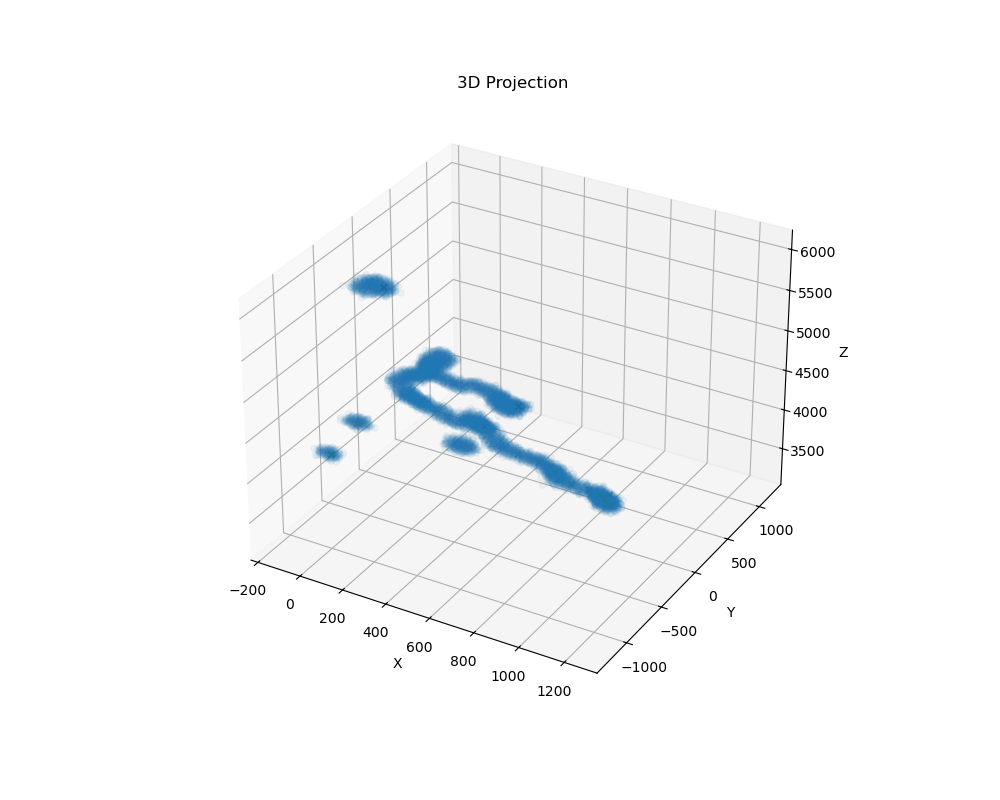

In [383]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(data['x'], data['y'], data['z'], marker='o',alpha=0.05)
# ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o',color="Teal")


for gid in sorted(databin.group_id.unique()):

    temp_df = databin[databin.group_id == gid]
    ax.scatter(temp_df['x'], temp_df['y'], temp_df['z'], marker='x')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()

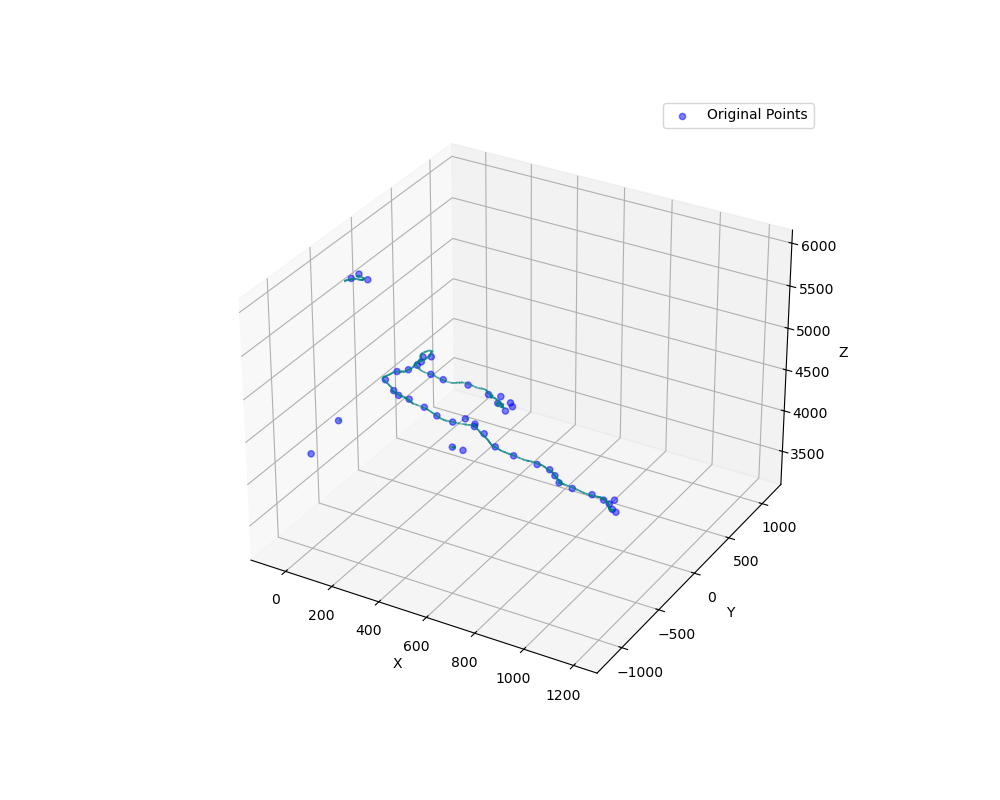

In [384]:

# Plot the original points and the polynomial fit
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(databin.x, databin.y,databin.z, color='blue', label='Original Points', alpha=0.5)
ax.scatter(data_true['x'], data_true['y'], data_true['z'],s=0.1 ,marker='o',color="Teal")

# Labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

,event_id,x_smear,y_smear,z_smear,x,y,z,energy,group_id
0,103725012.0,-84.0,-489.0,4131.0,-59.269302,-479.458923,4162.250977,0.064937,0
1,103725012.0,-3.0,-894.0,4131.0,-21.287706,-920.494263,4149.472656,0.020737,1
2,103725012.0,-3.0,-489.0,5913.0,22.200111,-499.403381,5919.726074,0.112690,2
3,103725012.0,78.0,-489.0,5994.0,41.537476,-460.899200,5956.475586,0.089227,2
4,103725012.0,78.0,-489.0,5913.0,78.755119,-461.130188,5919.776367,0.046712,2
5,103725012.0,78.0,726.0,3321.0,117.588669,759.218689,3280.800049,0.040218,3
6,103725012.0,159.0,1131.0,3321.0,161.189270,1120.343262,3300.750977,0.029130,4
7,103725012.0,645.0,-1137.0,5022.0,660.539246,-1159.699707,5000.530273,0.131130,5
8,103725012.0,645.0,-1056.0,5265.0,680.958435,-1059.474609,5260.024414,0.020461,5
9,103725012.0,726.0,-1137.0,4941.0,697.889160,-1142.704102,4981.268555,0.008638,5


Diffussion smear is:  0.95 mm/sqrt(cm)
Energy threshold is:  0.4 keV
diffision scale factor is:  4
Radius scale factor is:  2
Voxel scale factor is:  2.1
Median distance to the closest row: 62.74670113641338
Distances to iterate over [  1   9  18  27  36  45  54  63  72  81  89  98 107 116 125]
Dist Thresh 301.244
Pass Flag: True
The primary track is:  0
       event_id            x            y            z    energy  group_id  \
0   103725012.0   518.700500   -58.646736  4423.500977  0.072227         6   
1   103725012.0   536.780945   -22.049908  4460.552246  0.010506         6   
2   103725012.0   480.177673   -39.255600  4469.537598  0.310105         6   
3   103725012.0   467.789215    38.768665  4478.513672  0.006524         6   
4   103725012.0   421.451019    19.881153  4480.020996  0.162220         6   
5   103725012.0   320.996811    59.884943  4480.722656  0.066193         6   
6   103725012.0   220.181274    40.070400  4479.547852  0.026955         6   
7   103725012.0   1

,event_id,x,y,z,energy,group_id,id,primary,trkID,cumulative_distance,angle,Tortuosity,Squiglicity
id,,,,,,,,,,,,,
28,103725012.0,518.700500,-58.646736,4423.500977,0.072227,6,28,1,0,0.000000,0.000000,1.484855,0.614283
29,103725012.0,536.780945,-22.049908,4460.552246,0.010506,6,29,1,0,55.127370,74.417879,1.425970,0.620652
26,103725012.0,480.177673,-39.255600,4469.537598,0.310105,6,26,1,0,114.966343,113.590711,1.358257,0.557098
25,103725012.0,467.789215,38.768665,4478.513672,0.006524,6,25,1,0,194.476278,96.766522,1.405934,0.714527
23,103725012.0,421.451019,19.881153,4480.020996,0.162220,6,23,1,0,244.538625,102.862477,1.443810,0.764592
21,103725012.0,320.996811,59.884943,4480.722656,0.066193,6,21,1,0,352.667453,43.901871,1.752939,1.001404
18,103725012.0,220.181274,40.070400,4479.547852,0.026955,6,18,1,0,455.418456,32.848725,1.766494,1.009867
15,103725012.0,160.381989,59.025414,4480.926758,0.019542,6,15,1,0,518.165157,28.768773,2.059239,1.385330
14,103725012.0,129.107433,159.184101,4591.169678,0.021441,6,14,1,0,670.360302,65.760131,1.892954,1.373154


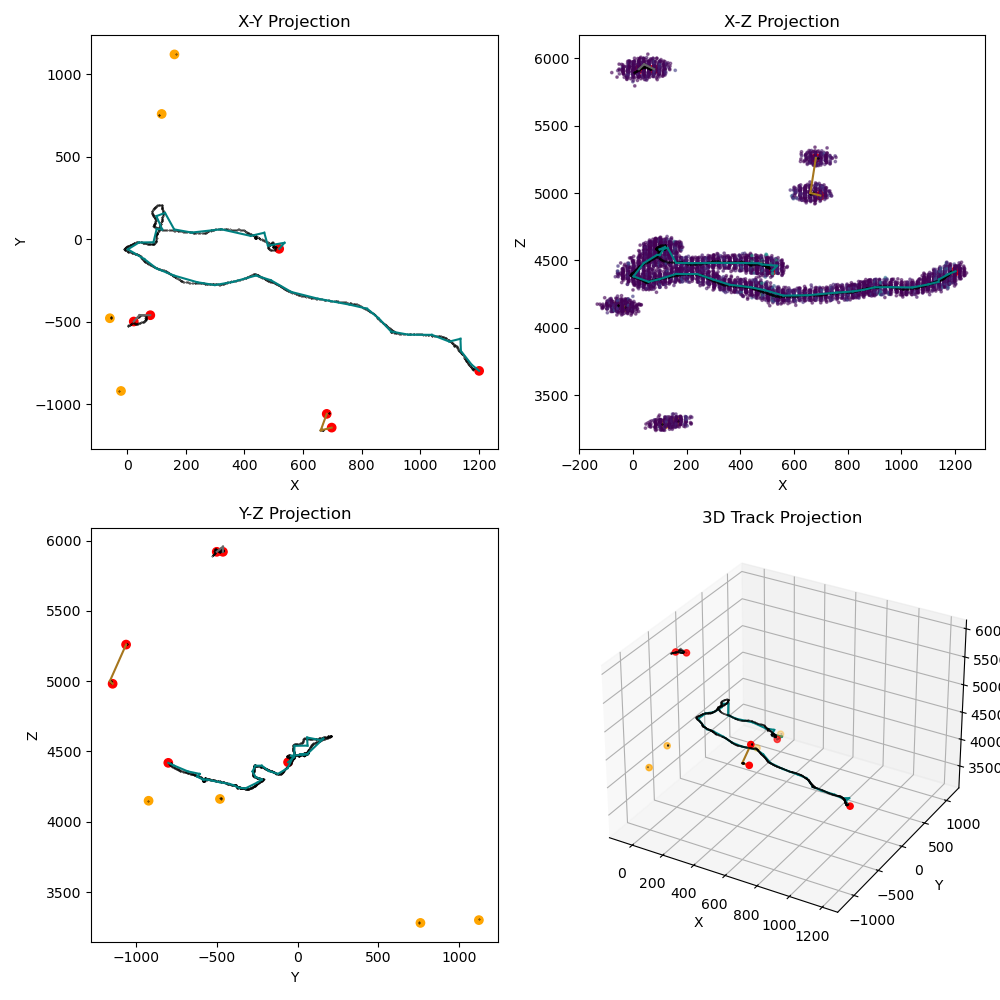

In [385]:
# Apply the tracking reconstruction

display(databin)


# df, Tracks, connected_nodes, connection_count, pass_flag = RunTracking(databin[["event_id", "x", "y", "z", "energy"]], 0, 1, "5percent", 0)
df, Tracks, connected_nodes, connection_count, pass_flag = RunTracking(databin[["event_id", "x", "y", "z", "energy", "group_id"]], 0, pressure, diffusion, 0)

df.index = df.id

display(df)

# Create subplots
fig = plt.figure(figsize=(10, 10))

axs = [fig.add_subplot(2, 2, i + 1) for i in range(3)]

# Plot xy projection
plot_tracks(axs[0], df['x'], df['y'], connection_count, 'X', 'Y', Tracks)
# axs[0].scatter(data.x, data.y, c=colors, marker='o', alpha=0.5,s=3)
axs[0].scatter(data_true['x'], data_true['y'], marker='o',c="k", s=0.1)

# Plot xz projection
plot_tracks(axs[1], df['x'], df['z'], connection_count, 'X', 'Z', Tracks)
axs[1].scatter(data.x, data.z, c=colors, marker='o', alpha=0.5,s=3)
axs[1].scatter(data_true['x'], data_true['z'], marker='o',c="k", s=0.1)

# Plot yz projection
plot_tracks(axs[2], df['y'], df['z'], connection_count, 'Y', 'Z', Tracks)
# axs[2].scatter(data.y, data.z, c=colors, marker='o', alpha=0.5,s=3)
axs[2].scatter(data_true['y'], data_true['z'], marker='o',c="k", s=0.1)


# 3D Projection
ax_3D = fig.add_subplot(2, 2, 4, projection='3d')
plot_tracks_3D(ax_3D, df['x'], df['y'], df['z'], connection_count, Tracks)
ax_3D.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o',c="k", s=0.1)
# ax_3D.scatter(data.x, data.y, data.z, c=colors, marker='o', alpha=0.5,s=3)

plt.tight_layout()
plt.show()

In [386]:
temp_meta = GetTrackdf(df, Tracks, 500/pressure, 180/pressure, 200/pressure, pressure) # scale these params inversely with the pressure
temp_meta = UpdateTrackMeta(temp_meta, df, 100/pressure) # Merge deltas and brems that are near the blobs in the metadata
display(temp_meta)

,event_id,trkID,primary,start,end,length,energy,blob1,blob2,blob1R,blob2R,Tortuosity1,Tortuosity2,TortuosityA1,TortuosityA2,Squiglicity1,Squiglicity2,SquiglicityA1,SquiglicityA2,label
0,103725012.0,0,1,28,45,2804.075,2.004532,0.654730,0.450332,0.561583,0.178516,1.418754,1.204420,273.426055,181.670094,0.626640,0.552446,119.830399,89.310929,Primary
0,103725012.0,1,0,0,0,0.000,0.064937,0.064937,0.064937,0.064937,0.064937,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Brem
0,103725012.0,2,0,1,1,0.000,0.020737,0.020737,0.020737,0.020737,0.020737,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Brem
0,103725012.0,3,0,12,12,0.000,0.040218,0.040218,0.040218,0.040218,0.040218,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Brem
0,103725012.0,4,0,17,17,0.000,0.029130,0.029130,0.029130,0.029130,0.029130,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Brem
0,103725012.0,5,0,33,34,324.256,0.160229,0.160229,0.160229,0.020461,0.139768,1.112721,1.112721,310.365934,50.440538,0.152630,0.152630,42.572334,6.918837,Brem
0,103725012.0,6,0,3,7,108.900,0.248629,0.248629,0.248629,0.248629,0.248629,1.594700,1.594700,173.662196,173.662196,0.817715,0.817715,89.048788,89.048788,Brem


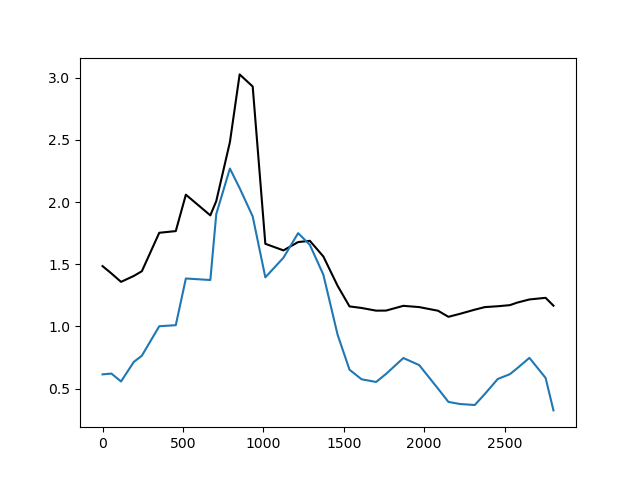

In [387]:
plt.figure()

plt.plot(df[df.primary == 1].cumulative_distance, df[df.primary == 1].Tortuosity, color="k");
plt.plot(df[df.primary == 1].cumulative_distance, df[df.primary == 1].Squiglicity);